# Movie Recommender System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io 
import scipy.optimize 



%matplotlib inline

In [8]:
datafile = 'movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']

nm, nu = Y.shape

Average rating for movie 1 (Toy Story): 3.88


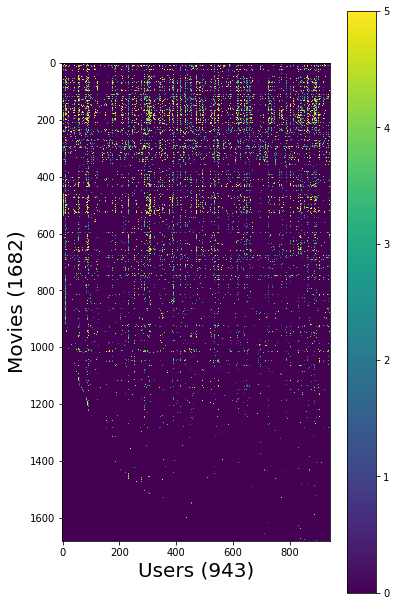

In [9]:
print ('Average rating for movie 1 (Toy Story): %0.2f' % \
    np.mean([ Y[0][x] for x in range(Y.shape[1]) if R[0][x] ]))

fig = plt.figure(figsize=(6,6*(1682./943.)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.ylabel('Movies (%d)'%nm,fontsize=20)
dummy = plt.xlabel('Users (%d)'%nu,fontsize=20)

In [41]:

datafile = 'movieParams.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])

nu = 4; nm = 5; nf = 3
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm,:nu]
R = R[:nm,:nu]

In [14]:
def flattenParams(myX, myTheta):
    return np.concatenate((myX.flatten(),myTheta.flatten()))

def reshapeParams(flattened_XandTheta, mynm, mynu, mynf):
    assert flattened_XandTheta.shape[0] == int(nm*nf+nu*nf)
    
    reX = flattened_XandTheta[:int(mynm*mynf)].reshape((mynm,mynf))
    reTheta = flattened_XandTheta[int(mynm*mynf):].reshape((mynu,mynf))
    
    return reX, reTheta

In [15]:
def cofiCostFunc(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    myX, myTheta = reshapeParams(myparams, mynm, mynu, mynf)
  
    term1 = myX.dot(myTheta.T)
    
    term1 = np.multiply(term1,myR)
    
    cost = 0.5 * np.sum( np.square(term1-myY) )
   
    cost += (mylambda/2.) * np.sum(np.square(myTheta))
    cost += (mylambda/2.) * np.sum(np.square(myX))
    
    return cost


In [17]:
print ('Cost with nu = 4, nm = 5, nf = 3 is %0.2f.' % \
    cofiCostFunc(flattenParams(X,Theta),Y,R,nu,nm,nf))
    
print ('Cost with nu = 4, nm = 5, nf = 3 (and lambda = 1.5) is %0.2f.' % \
    cofiCostFunc(flattenParams(X,Theta),Y,R,nu,nm,nf,mylambda=1.5))

Cost with nu = 4, nm = 5, nf = 3 is 22.22.
Cost with nu = 4, nm = 5, nf = 3 (and lambda = 1.5) is 31.34.


In [19]:
def cofiGrad(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    myX, myTheta = reshapeParams(myparams, mynm, mynu, mynf)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1,myR)
    term1 -= myY
    Xgrad = term1.dot(myTheta)
    Thetagrad = term1.T.dot(myX)
    Xgrad += mylambda * myX
    Thetagrad += mylambda * myTheta
    
    return flattenParams(Xgrad, Thetagrad)

In [26]:
def checkGradient(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    print ('Numerical Gradient \t cofiGrad \t\t Difference')
    
    myeps = 0.0001
    nparams = len(myparams)
    epsvec = np.zeros(nparams)
    mygrads = cofiGrad(myparams,myY,myR,mynu,mynm,mynf,mylambda)
    
    for i in range(10):
        idx = np.random.randint(0,nparams)
        epsvec[idx] = myeps
        loss1 = cofiCostFunc(myparams-epsvec,myY,myR,mynu,mynm,mynf,mylambda)
        loss2 = cofiCostFunc(myparams+epsvec,myY,myR,mynu,mynm,mynf,mylambda)
        mygrad = (loss2 - loss1) / (2*myeps)
        epsvec[idx] = 0
        print ('%0.15f \t %0.15f \t %0.15f' % \
        (mygrad, mygrads[idx],mygrad - mygrads[idx]))

In [27]:
print ("Checking gradient with lambda = 0...")
checkGradient(flattenParams(X,Theta),Y,R,nu,nm,nf)
print ("\nChecking gradient with lambda = 1.5...")
checkGradient(flattenParams(X,Theta),Y,R,nu,nm,nf,mylambda = 1.5)

Checking gradient with lambda = 0...
Numerical Gradient 	 cofiGrad 		 Difference
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-3.474107886720645 	 -3.474107886729185 	 0.000000000008539
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-3.050990064075165 	 -3.050990064071511 	 -0.000000000003654
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-0.353340482881492 	 -0.353340482875070 	 -0.000000000006423
-1.899790261372658 	 -1.899790261386604 	 0.000000000013946
2.263336983912012 	 2.263336983921972 	 -0.000000000009960
-0.740408710786511 	 -0.740408710778314 	 -0.000000000008196
-0.766778776704058 	 -0.766778776703673 	 -0.000000000000385

Checking gradient with lambda = 1.5...
Numerical Gradient 	 cofiGrad 		 Difference
4.089852197868282 	 4.089852197893254 	 -0.000000000024972
-0.892473343601097 	 -0.892473343597432 	 -0.000000000003664
1.092897577699148 	 1.092897577688307 	 0.000000000010841
-0.197479281052182 	 -0.197479281036198 	 -0.000000000015984

In [29]:
movies = []
with open('movie_ids.txt') as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))

my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [31]:
datafile = 'movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
nf = 10
myR_row = my_ratings > 0
Y = np.hstack((Y,my_ratings))
R = np.hstack((R,myR_row))
nm, nu = Y.shape

In [32]:
def normalizeRatings(myY, myR):

    # The mean is only counting movies that were rated
    Ymean = np.sum(myY,axis=1)/np.sum(myR,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return myY-Ymean, Ymean

In [34]:

Ynorm, Ymean = normalizeRatings (Y,R)

In [35]:
X = np.random.rand(nm,nf)
Theta = np.random.rand(nu,nf)
myflat = flattenParams(X, Theta)

mylambda = 10.

result = scipy.optimize.fmin_cg(cofiCostFunc, x0=myflat, fprime=cofiGrad, \
                               args=(Y,R,nu,nm,nf,mylambda), \
                                maxiter=50,disp=True,full_output=True)

         Current function value: 72881.832598
         Iterations: 50
         Function evaluations: 73
         Gradient evaluations: 73


In [36]:
resX, resTheta = reshapeParams(result[0], nm, nu, nf)

In [40]:
prediction_matrix = resX.dot(resTheta.T)
my_predictions = prediction_matrix[:,-1] + Ymean.flatten()
pred_idxs_sorted = np.argsort(my_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

print ("Top recommendations for you:")
for i in range(10):
    print ('Predicting rating %0.1f for movie %s.' % \
    (my_predictions[pred_idxs_sorted[i]],movies[pred_idxs_sorted[i]]))
    
print ("\nOriginal ratings provided:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print ('Rated %d for movie %s.' % (my_ratings[i],movies[i]))

Top recommendations for you:
Predicting rating 8.5 for movie Star Wars (1977).
Predicting rating 8.4 for movie Shawshank Redemption, The (1994).
Predicting rating 8.3 for movie Schindler's List (1993).
Predicting rating 8.3 for movie Raiders of the Lost Ark (1981).
Predicting rating 8.2 for movie Titanic (1997).
Predicting rating 8.2 for movie Wrong Trousers, The (1993).
Predicting rating 8.2 for movie Usual Suspects, The (1995).
Predicting rating 8.2 for movie Close Shave, A (1995).
Predicting rating 8.1 for movie Empire Strikes Back, The (1980).
Predicting rating 8.0 for movie Braveheart (1995).

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 for movi